<a href="https://colab.research.google.com/github/dbeniteze/autoencoder_convolucional/blob/master/cifar10_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install keras==2.3.1

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

     |████████████████████████████████| 378kB 4.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 1, 32, 32, 3)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 1, 32, 32, 3)).astype('float32')

#X_train_mean = np.mean(X_train, axis=(0,1,2))
#X_train_std = np.std(X_train, axis=(0,1,2))
#X_train = (X_train - X_train_mean) / X_train_std
#X_test = (X_test - X_train_mean) / X_train_std


def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

#X_train = grayscale(X_train)
#X_test = grayscale(X_test)

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255


epoch = 100

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 70:
        lrate = 0.0003
    return lrate


In [0]:
from keras.layers import  Add, Activation

#autoencoder con Conv2DTranspose
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
LF = (5,5)  
e1 = Conv2D(64, kernel_size=LF, activation='relu')(input_img)   
e1 = BatchNormalization()(e1)
e2 = Conv2D(32, kernel_size=LF,   activation='relu')(e1)         
e2 = BatchNormalization()(e2)
e3 = Conv2D(32, kernel_size=LF,   activation='relu')(e2)         
e3 = BatchNormalization()(e3)




e4 = Conv2D(16, kernel_size=LF, strides=2, padding= "same",activation='relu')(e3)  
e4 = BatchNormalization()(e4)
e5 = Conv2D(16, kernel_size=LF, strides=2, padding= "same",activation='relu')(e4)
e5 = BatchNormalization()(e5)



e6 = Conv2D(8, kernel_size=LF, padding= "same",activation='relu')(e5)
e6 = BatchNormalization()(e6)
e7 =Conv2D(4, kernel_size=LF, padding= "same", activation='relu')(e6)

#encoded = Model(input_img, encoded)
#encoded.summary()

d1 = Conv2DTranspose(4, kernel_size=LF, padding= "same", activation='relu')(e7)
d1 = BatchNormalization()(d1)
d2 = Conv2DTranspose(8, kernel_size=LF, padding= "same", activation='relu')(d1)
d2 = BatchNormalization()(d2)


d3 = Conv2DTranspose(16, kernel_size=LF, strides=2, padding= "same", activation='relu')(d2)
d3 = BatchNormalization()(d3)
d4 = Conv2DTranspose(32, kernel_size=LF, strides=2, padding= "same", activation='relu')(d3)
d4 = BatchNormalization()(d4)

d4_e3 = Add()([d4, e3])  #union
clayer_dlayer = Activation(activation='relu')(d4_e3)



d5 = Conv2DTranspose(32, kernel_size=LF,  activation='relu')(clayer_dlayer)
d5 = BatchNormalization()(d5)
d6 = Conv2DTranspose(64, kernel_size=LF,  activation='relu')(d5)
d6 = BatchNormalization()(d6)
d7 = Conv2DTranspose(3, kernel_size=LF, activation='relu')(d6)

#z = Add()([input_img, d7])  #union
#y = Activation(activation='relu')(z)

autoencoder = Model(input_img, d7)
autoencoder.summary()

In [11]:
from keras.layers import Input, LSTM, RepeatVector, ConvLSTM2D
from keras.models import Model


#autoencoder con Conv2DTranspose
input_img = Input(shape=(None, 32, 32, 3))  # adapt this if using `channels_first` image data format
LF = (3,3)
x = ConvLSTM2D(32, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(input_img)
x = BatchNormalization()(x)


x = ConvLSTM2D(8, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(x)
x = BatchNormalization()(x)

encoded = Reshape((8, 8, 8))(x)

x = Conv2DTranspose(8, kernel_size=LF, strides=2, padding="same", activation='elu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(3, kernel_size=LF,  strides=2,padding="same", activation='elu')(x)
decoded = Reshape((1, 32, 32, 3))(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None, 32, 32, 3)   0         
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, None, 16, 16, 32)  40448     
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 16, 16, 32)  128       
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, None, 8, 8, 8)     11552     
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 8, 8, 8)     32        
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 16, 16, 8)         584 

In [12]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule(epoch)),  loss='mse', metrics=[coeff_determination])

autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 16s 326us/step - loss: 0.1813 - coeff_determination: -1.8725 - val_loss: 0.0885 - val_coeff_determination: -0.4054
Epoch 2/100
50000/50000 [==============================] - 8s 167us/step - loss: 0.0474 - coeff_determination: 0.2488 - val_loss: 0.0280 - val_coeff_determination: 0.5570
Epoch 3/100
50000/50000 [==============================] - 8s 168us/step - loss: 0.0238 - coeff_determination: 0.6223 - val_loss: 0.0192 - val_coeff_determination: 0.6968
Epoch 4/100
50000/50000 [==============================] - 8s 169us/step - loss: 0.0164 - coeff_determination: 0.7403 - val_loss: 0.0131 - val_coeff_determination: 0.7926
Epoch 5/100
50000/50000 [==============================] - 8s 166us/step - loss: 0.0125 - coeff_determination: 0.8024 - val_loss: 0.0103 - val_coeff_determination: 0.8370
Epoch 6/100
50000/50000 [==============================] - 9s 171us/step - loss: 0.0098 - co

In [0]:
decoded_imgs = autoencoder.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


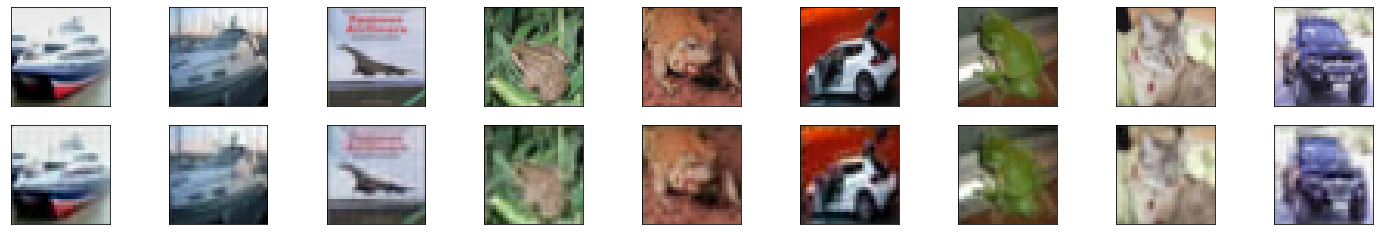

In [14]:
#visualizacion de la decodificacion

X_test = X_test.reshape((X_test.shape[0], 32, 32, 3))
decoded_imgs = decoded_imgs.reshape((decoded_imgs.shape[0], 32, 32, 3))

n = 9
plt.figure(figsize=(25, 4))
for i in range(n):
    i = i + 1
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
